## ECON 2355 Implementation Exercise 2: Convolutional Neural Nets

This exercise has two main parts:
 - **1: Convolutions from Scratch**: (_Optional_) This task is designed to build familiarity with Convolutional Neural Networks by implementing a convolutional model from (almost) scratch and building a small model using those layers.
 - **2: CNNs for Remote Sensing**: (_Required_) This task applies several modern Convolutional Networks (VGG, ResNet, ConvNeXt, and MobileNetv3) to a satelite imagery dataset, comparing and contrasting the various models.   

If you are not deeply familiar with Neural Networks, completing Part 1 is strongly advised. An understanding of how these models work at a lower level is crucial to developing intuition around newer developments.  

### Notes on the class's implementation exercises in general:

 - These exercises are still being finalized! If you encounter problems please don't hesitate to reach out: tom_bryan@fas.harvard.edu

 - You are welcome to download these notebooks and complete them on your local machine, or work on them in colab. If you are hoping to run things on your local machine you will likely want to set up an [Anaconda](https://www.anaconda.com/products/distribution) python environment and run notebooks from either [VS Code](https://code.visualstudio.com/download) or [Jupyter Lab](https://jupyterlab.readthedocs.io/en/stable/getting_started/installation.html). For your future Deep Learning-oriented endevours, knowing how to set up an environment to run the frameworks and libraries discussed here will likely be important, so it might not be a bad idea to try setting things up locally. On the other hand, working in colab is nice for reproducibility purposes--anyone can run and/or debug your code without problems.

 - Exercises in this class use [PyTorch](https://pytorch.org/get-started/locally/), the [dominant](https://www.assemblyai.com/blog/pytorch-vs-tensorflow-in-2023/) research deep learning python framework. If you have a _compelling_ reason why you wish to become more familiar with another framework, like Tensorflow, reach out and we _may_ be able to accomodate that.

 - In these exercises we'll try to find the sweet spot between providing so much of the code that the implementation is meaningless and leaving so much that the work is overly tedious. Feedback is appreciated!

 - To submit the assignements, please save the exercise as a `.ipynb` file named `ECON_2355_Exercise_{n}_{firstname}_{lastname}.ipynb` and submit to the appropriate place in XXXXX  

 - These exercises are graded as complete/incomplete. _Complete_ is defined as showing effort to complete at least half of the steps.

 - Many of these exercises are adapted from other courses, tutorials, or other sources. Like any good social scientist, I list those sources, so should you choose there are often other places to look for help/partial solutions. How and when you use those resources are entirely up to you and your learning style. One caveat: outside sources for exercises will likely be less and less common as we progress through the course.  

### Exercise Set 2: CNN from scratch and Transfer Learning with Remote Sensing

As mentioned above, this exercise has two parts: The first is optional and guides you through creating a Convolutional Neural Network from scratch, i.e. you will actually implement the Convolution operation, maxpooling, the ReLU activation function, etc.

The second part will walk you through a plausible use case for modern convolutional neural networks: classifying land use based on satelite imagery. You will compare multiple ConvNets mentioned in the lecture and readings, and use [Weights and Biases](https://wandb.ai/), a popular Deep Learning experiment tracking/evaluation platform to compare models.

#### Part 1: Convolutional Neural Network from Scratch (Optional)

This section will walk you through creating a Convolutional Neural Network from only basic mathematical operations and matrix math. (And the incredible PyTorch backpropagation framework, of course!) In particular, we'll be recreating a smaller version of the Convolutional Network from the last exercises (the one that classified handwritten images of numbers). We make the model here smaller because we are not able to take advantage of PyTorch's extremely fast operations, so a smaller model allows us to train and infer in a reasonable amount of time.



##### a) **Bringing in Data**

We're working with the same data as before, so code to download the data, create the `Dataset` and `Dataloader` objects, and transform the data appropriately is all provided.

In [ ]:
import os
from matplotlib import pyplot as plt
import numpy as np
from matplotlib import pyplot as plt
import torch
import torchvision
from math import sqrt

train_data = torchvision.datasets.MNIST('/files/', train=True, download=True)
test_data = torchvision.datasets.MNIST('/files/', train=False, download=True)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(train_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(train_data[i][1]))
  plt.xticks([])
  plt.yticks([])
fig

In [ ]:
#Create the datasets
train_dataset = torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

test_dataset = torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

train_batch_size = 64
test_batch_size = 1

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = train_batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = test_batch_size, shuffle=True)

##### b) **ReLu Layer**

We will be creating `torch.nn.Module` subclasses for each of the modules we used in our Convolutional Neural Network. That is, we will need to create our own classes to mimic all of:


*   `torch.nn.ReLU`
*   `torch.nn.Conv2d`
*   `torch.nn.MaxPool2d`
*   `torch.nn.Linear`
*   `torch.nn.Dropout2d`
*   `torch.nn.Softmax`

The basic format for these classes is fairly simple: we just need to implement a `__init__` function which saves any necessary layer parameters, and initializes any weights and biases, and we need to define a `forward` function, which will pass data through the layer.

This first example is quite simple: we need to create a module that will pass data through a ReLU nonlinear activation function. ReLU is defined as:
$$f(x) = max(0, x)$$

Since this module doesn't need any additional parameters or stored information, we can leave `__init__` as is. All you need to do is modify `forward` (hint, `torch.maximum` and `torch.zeros_like` may be helpful) to evaluate ReLU over each value in `x`

In [ ]:
class ReluLayer(torch.nn.Module):
  def __init__(self):
    super(ReluLayer, self).__init__()

  def forward(self, x):
    # TODO: evaluate ReLU(x)
    return torch.maximum(x, torch.zeros_like(x))

##### c) **MaxPool Layer**

The MaxPool operation is relatively simple: given a tensor with shape (batch, n_channels, width, height), MaxPool will return a tensor with shape (batch, n_channels, width / size, height / size), where (size x size) square blocks in the last two dimensions have been "pooled" by keeping only the maximum value in the pool. For more information, see [`torch.nn.MaxPool2d`](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html).

Here, your task is to implement the pooling operation itself. Fill the provided `result` tensor with its appropriate values. Hint: `torch.max` will work, and passing in a dimension argument to assign all batches and channels simultaneously will make things much faster. A naive implementation will work fine for what we need here though.

In [ ]:
class MaxPoolLayer(torch.nn.Module):
  def __init__(self, size):
    super(MaxPoolLayer, self).__init__()
    self.size = size

  def forward(self, x):
    if x.size()[-1] % self.size != 0 or x.size()[-2] % self.size != 0:
      raise ValueError('Tensor is invalid size! Maxpool Kernel must fit evenly within Tensor')

    result = torch.empty(x.size()[0], x.size()[1], x.size()[2] // self.size, x.size()[3] // self.size, device=x.device)

    # TODO: assign `result` with the correct values found by taking maxes over sections of x
    for xi in range(x.size()[2] // self.size):
      for yi in range(x.size()[3] // self.size):
        result[:, :, xi, yi] = torch.max(torch.max(x[:, :, xi * self.size : (xi + 1) * self.size, yi * self.size : (yi + 1) * self.size], dim=3)[0], dim=2)[0]
    return result

##### d) **Convolutional Layer**

A convolutional layer (see [`torch.nn.Conv2d`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)) passes several sliding windows (called "Kernels") over a multi-layered tensor, with each kernel creating its own new layer.

Intunitively, each kernel will start in the upper left corner of the image, compute element-wise multiplication with the section of the input they cover, and then move one space to the right. They then compute the same element-wise multiplication with that section of the image, and continue until the reach the right side of the image. They then move one space down and repeat until they have covered the entire image.

Since running convolutions in a time-efficent way is somewhat complicated, this section is provided.

In [ ]:
class ConvLayer(torch.nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size):
    super(ConvLayer, self).__init__()
    self.kernel_size = kernel_size
    self.out_channels = out_channels
    self.in_channels = in_channels
    self.pad_n = (self.kernel_size - 1) // 2
    self.padder = torch.nn.ConstantPad2d(self.pad_n, 0)
    bounds = in_channels * kernel_size * kernel_size
    self.kernels = torch.nn.Parameter(torch.empty(self.in_channels * self.kernel_size * self.kernel_size, self.out_channels).uniform_(-1 / sqrt(bounds), 1 / sqrt(bounds)))
    self.biases = torch.nn.Parameter(torch.empty(self.out_channels).uniform_(-1 / (self.kernel_size ** 2), 1 / self.kernel_size ** 2))

  def forward(self, x):
    result = torch.empty(x.size()[0], self.out_channels, x.size()[2], x.size()[3], device=x.device)
    x = self.padder(x)

    for xi in range(self.pad_n, x.size()[2] - (self.pad_n + 2)):
      for yi in range(self.pad_n, x.size()[3] - (self.pad_n + 2)):
        res = x[:, :, xi: xi + self.kernel_size, yi : yi + self.kernel_size].flatten(start_dim=1) @ self.kernels
        result[:, :, xi - self.pad_n, yi - self.pad_n] = res + self.biases

    return result[:, :, self.pad_n:-1*self.pad_n, self.pad_n:-1*self.pad_n]


##### d) **Linear Layer**

Linear Layers ([`torch.nn.Linear'](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)) simply multiply their input by a learnable matrix, and add a learnable bias vector. Here you will need to implement the class `LinearLayer` from scratch, by initializing the `weights` tensor as a `torch.nn.Parameter` instance containing a `Tensor` with shape `(in_channels, out_channels)` with initial values drawn randomly from the standard normal distribution (see `torch.randn`). `biases` will need to be similarly initialized, but with shape `(out_channels,)`.

In `forward` you will need to appropriately define the behavior for the linear layer.

In [ ]:
class LinearLayer(torch.nn.Module):
  def __init__(self, in_channels, out_channels):
    super(LinearLayer, self).__init__()
    self.weights = torch.nn.Parameter(torch.empty(in_channels, out_channels).uniform_(-1 / sqrt(in_channels), 1 / sqrt(in_channels)))
    self.biases = torch.nn.Parameter(torch.empty(out_channels).uniform_(-1, 1))

  def forward(self, x):
    return x @ self.weights + self.biases

##### e) **SoftMax "Layer"**

The softmax function is defined by:


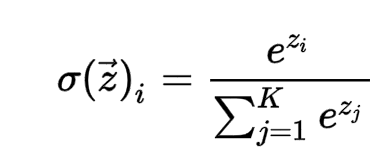

In the context of this "layer," you will need to compute the softmax over the ten value row of the final, `(batch_size, 10)` dimensional output of the model. Do this explicitly, without using `torch.nn.Softmax` of `torch.nn.F.Softmax`.  Hint: you will want to leverage the `dim` argument of `torch.exp`.

In [ ]:
class SoftMaxLayer(torch.nn.Module):
  def __init__(self):
    super(SoftMaxLayer, self).__init__()

  def forward(self, x):
    return (torch.exp(x).T / torch.exp(x).sum(dim=1)).T

##### f) **Dropout "Layer"**

Dropout layers randomly assign some percentage of the parameters in the layer to zero. Here we pass `p` as a parameter to the layer, and in the `forward` function replace that percentage of the values in `x` with zeros. You will need to implement the `forward` function.

In [ ]:
class DropoutLayer(torch.nn.Module):
  def __init__(self, p = 0.5):
    super(DropoutLayer, self).__init__()
    self.p = p

  def forward(self, x):
    mask = torch.rand(x.size(), device = x.device) > self.p
    return (x * mask) * (1 / (1 - self.p))


##### g) **Finishing the Process**

Now we need to implement a standard PyTorch training loop for the model using the layers we've created. First, we provide a definintion for the model using the new layers we've defined, which looks very similar to the model we used in the first exercises.

The primary difference is that we've made several of the layers slightly smaller, because this model will train much more slowly than the model used in the previous exercises, since we are no longer able to leverage PyTorch's extremely fast built in evaluation and backpropagation algorithms.

In [ ]:
class DigitsModel(torch.nn.Module):
  def __init__(self):
    super(DigitsModel, self).__init__()

    ## 1: First convolutional layer, with additional steps
    self.conv1 = ConvLayer(1, 5, 5)
    self.maxpool1 = MaxPoolLayer(2)
    self.relu1 = ReluLayer()

    ## 2: Second convolutional layer, with additional steps
    self.conv2 = ConvLayer(5, 5, 5)
    self.dropout1 = DropoutLayer()
    self.maxpool2 = MaxPoolLayer(2)
    self.relu2 = ReluLayer()

    ## 4: First fully connected layer, with additional steps
    self.fc1 = LinearLayer(80, 50)
    self.relu3 = ReluLayer()
    self.dropout2 = DropoutLayer()

    ## 5: Second fully connected layer, with additional steps
    self.fc2 = LinearLayer(50, 10)
    self.softmax = SoftMaxLayer()

  def forward(self, x):
    # Step 1: output shape should be 64x10x14x14
    x = self.relu1(self.maxpool1(self.conv1(x)))

    # Step 2: output shape should be 64x20x5x5
    x = self.relu2(self.maxpool2(self.dropout1(self.conv2(x))))

    # Step 3: output shape should be 64x80
    x = x.view(-1, 80)

    # Step 4: output shape should be 64x50
    x = self.dropout2(self.relu3(self.fc1(x)))

    # Step 5: output shape should be 64x10
    x = self.softmax(self.fc2(x))

    # Return the output
    return x

This cell defines the loss function, instantiates the model, moves is to the GPU, and creates the optimizer just as in the last exercises.

In [ ]:
learning_rate = 0.01
momentum = 0.5

## Initialize Cross Entropy Loss Function
loss_fn = torch.nn.CrossEntropyLoss()

## Initializer the model and optimizer
model = DigitsModel()
model = model.cuda()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum = momentum)

Finally, we run the standard PyTorch training loop on with the defined model, optimizer, and loss function. If the model throws errors, try to isolate which layers are causing them and carefully check the shapes, logic, and other features of the layer.

We've set the model to train for only two epochs, since this model will take a while to train. With our implementation it averages 160s/epoch on the GPu, but experiences may vary.

In [ ]:
from tqdm import tqdm

n_epochs = 1

for _ in range(n_epochs):

  for X, y in tqdm(train_loader):

    # Move X and y to the GPU
    X = X.cuda()
    y = y.cuda()

    # Create predictions by running the model
    preds = model(X)

    # Compute the loss with the loss function defined above
    loss = loss_fn(preds, y.long())

    # Zero the optimizer grads by calling optimizer.zero_grad()
    optimizer.zero_grad()

    # Call the `backward` function on the loss to compute the gradients
    loss.backward()

    # Call `step` on the optimzer to update the parameters
    optimizer.step()

**Finally**, check your model's preformance on the test set, again using code borrowed from the last exercise set. This model will likely preform worse than the model in the last exercises, for a variety of reasons:


1.   The model is much smaller than the previous one
2.   The model has been trained for fewer epochs.
3.   The model was initialized with suboptimal weights. See the paper below for one explaination of why weights drawn from our distributions may not be optimal, and for a derivation of more optimal intial weights.

However, we should still see the model learning and should observe some performance gains. After 2 epochs, performance under 50% should raise a red flag, but something between 50 and 70% is standard.

We recommend training for only a single epoch. Further training is likely to result in worse preformance and substantial overfitting.

K. He, X. Zhang, S. Ren, and J. Sun. Delving deep into rectifiers:
Surpassing human-level performance on imagenet classification. In
ICCV, 2015.

In [ ]:
n_correct = 0
count = 0
model.eval()

with torch.no_grad():
  for X, y in test_loader:
    if count > 100:
      break
    # Check if the model has predicted accurately
    X = X.cuda()
    y = y.cuda()
    output = model(X).cpu().detach().numpy()
    pred = np.argmax(output)
    count += 1
    if pred == y.item():
      n_correct += 1

print(n_correct / count)

### 2. Transfer Learning with Remote Sensing Data

This set of exercises introduces the `timm` library, which provides a wide variety of pretrained image models. Pretrained image models have been tuned to understand images by extensive training on a large dataset, typically ImageNet.

Let's start by installing the `timm` library.

In [ ]:
!pip install timm

And some necessary imports:

In [ ]:
import os
import torch
from PIL import Image
import torchvision
from matplotlib import pyplot as plt
import timm
from tqdm import tqdm
import numpy as np

Before we start talking about models, let's bring in an interesting dataset to work with. This is the [UC Merced Satelite Landuse Dataset](http://weegee.vision.ucmerced.edu/datasets/landuse.html), which includes images from 21 categories of Landuses. Our object will be to correctly classify the various landuses shown in the images.

To download the dataset and see examples of the various landuses, run the following cells.

In [ ]:
!wget http://weegee.vision.ucmerced.edu/datasets/UCMerced_LandUse.zip
!unzip -q UCMerced_LandUse.zip
os.chdir('UCMerced_LandUse')

In [ ]:
fig = plt.figure(figsize = (12, 12))
for i, cat in enumerate(os.listdir('./Images')):
  im = Image.open(os.path.join('./Images', cat, cat + '00.tif'))
  ax = fig.add_subplot(5, 5, i + 1)
  ax.imshow(im)
  ax.set_title(cat)

fig.tight_layout()
plt.show()

You should see the 21 different possible landuses, with examples of each, displayed above. (Fun fact that I learned from this, "Chaparral" is a kind of shrubland, primarily found in California, Oregon, and Mexico.)

##### a) **Creating Datasets and Dataloaders**

As per usual, we first need to create torch-style `torch.utils.data.Dataset` and `torch.utils.data.DataLoader` objects to load our data into a forthcoming training loop. Here we will create a train, validation, and test dataset.

Use `torch.utils.data.random_split` to divide the provided dataset into three, with an 80% train, 10% validation, and 10% test split. Then create associated `DataLoader` objects.

In [ ]:
landuse_dataset = torchvision.datasets.ImageFolder('./Images', transform=torchvision.transforms.Compose([
                                                                    torchvision.transforms.ToTensor(),
                                                                    torchvision.transforms.CenterCrop([256, 256])
                                                                    ]))

# TODO: Split the dataset into three with the provided sizes
train_set, val_set, test_set = torch.utils.data.random_split(landuse_dataset, [0.8, 0.1, 0.1])

train_batch_size = 16
val_batch_size = 16
test_batch_size = 1

# TODO: Create dataloader objects
train_loader = torch.utils.data.DataLoader(train_set, batch_size = train_batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size = val_batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = test_batch_size, shuffle=True)

##### b) **Downloading a Pretrained Model**

The `timm` library is prepared to provide us with a variety of model architectures and pretrained weights. Here is a first example, where we create a model (still a `torch.nn.Module` object) with the ConvNeXt architecture, which will classify samples into one of 21 classes (since there are 21 classes in our target dataset), and which is initialized with ImageNet pretrained weights. ConvNeXt is a powerful, modern convolutional architecture good for a wide variety of image classification, object detection, and other tasks.

In [ ]:
convnext_model = timm.create_model('convnext_tiny', num_classes = 21, pretrained=True)

##### c) **Creating a loss function and optimizer**

Similar to the last exercise set, we need to create a loss function and optimizer. We will again use `CrossEntropyLoss` for the loss function, but this time we will use an Adam (`torch.optim.Adam`) optimizer.

For more information on Adam, see here: https://arxiv.org/pdf/1412.6980.pdf. Adam is a specialized form of gradient descent that estimates different learning rates for different parameters based on the moments (in the mathematical sense) of their gradients. It tends to help large models converge faster.

In [ ]:
# TODO: Create the loss function
loss_fn = torch.nn.CrossEntropyLoss()

learning_rate = 1e-5

# TODO: Create the ADAM optimizer
optim = torch.optim.Adam(convnext_model.parameters(), lr = learning_rate)

##### d) **Training and Validation Loop**

Now that we have all the required objects, we are ready to start training! We will set up the training loop very similarly to the previous exercises, with one key addition: we add a _validation_ step, where we measure the model's progress by computing the accuracy on the validation set after each training epoch.

Five epochs should let this model learn the data fairly well.

In [ ]:
n_epochs = 5
convnext_model = convnext_model.cuda()

for i in tqdm(range(n_epochs)):

  # Train Step
  convnext_model.train()
  epoch_loss = []

  for X, y in train_loader:

    # TODO: Fill in the training loop
    X = X.cuda()
    y = y.cuda()

    optim.zero_grad()
    preds = convnext_model(X)
    loss = loss_fn(preds, y)
    loss.backward()
    optim.step()

  # Eval Step
  n_correct = 0
  for X, y in val_loader:

    # TODO: Compute the Validation Accuracy
    X = X.cuda()

    # Run the model over X to generate probabilities
    output = convnext_model(X)
    cpu_output = output.detach().cpu().numpy()
    # Find the maximal probability for each x to get predictions
    preds = np.argmax(cpu_output, axis = 1)
    # Determine if predictions were correct
    n_correct += (preds == y.numpy()).sum()

  print(f'Epoch {i}: val accuracy: {(n_correct / len(val_set)):3f}')

##### e) **Model Testing**

Finish this section by evaluating the trained model on your test set. How does the model do? Test accuracy should be close to final validation accuracy, and both should be close to 90% for this problem.

In [ ]:
convnext_model.eval()
n_correct = 0

with torch.no_grad():
  for X, y in test_loader:
    # Check if the model has predicted accurately
    X = X.cuda()
    y = y.cuda()
    output = convnext_model(X).cpu().detach().numpy()
    pred = np.argmax(output, axis = 1)

    n_correct += (pred == y.cpu().detach().numpy()).sum()

print(f'Test accuracy: {(n_correct / len(test_set)):3f}')

##### f) **Continued Exploration**

Follow a similar process to train a series of other models on this dataset. For each model, notice how it learns compared to this first ConvNeXt model. Why do you think they learn faster or slower?

Start by training the same `convnext_tiny` model, but without pretrained weights. How does the model do on the validation set? On the training set? How does pretraining account for the difference?

Next, train at least two other models from `timm`. To see a list of available models, you can run `timm.list_models(pretrained=True)`

Suggested, interesting models could include:


*   ResNet, in one or more of its forms
*   MobileNetv3
*   VGG16 or VGG19
*   A vision transformer model like vit or swin

You need to experiment with various model hyperparameters to find ones that allow your models to train quickly. Some models are particularly sensitive to the learning rate. When you have finished, write a few sentences about what you've noticed while training the various models.

